In [1]:
import os, glob, json
import pickle
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
import random, math
from tqdm import tqdm
import platform

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))
scr_dir = os.listdir(f"/{machine_name}")[0]

DISK_IO_DIR = "/{}/{}/yiweil".format(machine_name,scr_dir) ## CHANGE CSID
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)
    
from utils import *
STANZA_DIR

john2
scr1
/john2/scr1/yiweil
Using Δ|&#8710;|∆|!delta as regex for comments awarding delta.
Found 422 conversations which are manually checked to be true climate convos.


'/nlp/u/yiweil/combined_stanza_output_with_ner_embed_removed'

In [2]:
from convokit import Corpus#, Speaker, download
AVAILABLE_CORP = ['full_cmv','matched_cmv_subsample','gen_reddit']
corp_name_to_filepath = {
                         'full_cmv': '/u/scr/yiweil/convokit_corpora/my-cmv-corpus_1-1-2010_to_09-24-2021',
                         'matched_cmv_subsample': '/u/scr/yiweil/subsampled_cmv_corpus',
                         'gen_reddit':'/u/scr/yiweil/datasets/convokit/reddit-corpus-small',
                         'switchboard':'/sailhome/yiweil/.convokit/downloads/switchboard-corpus'
                        }

In [3]:
corp_to_analyze = {'full_cmv': None}#,'gen_reddit': None,'switchboard':None}
#corp_to_analyze.update({'matched_cmv_subsample': None})

for corp_name in corp_to_analyze:
    if corp_to_analyze[corp_name] is None:
        print("Loading corpus: {}...".format(corp_name))
        corp_to_analyze[corp_name] = Corpus(filename=corp_name_to_filepath[corp_name])
        corp_to_analyze[corp_name].print_summary_stats()
        print('\n')
        
        # Update full meta for conversations if corpus is not `matched_cc_cmv_subsample` (contains comments only, by design)
        if corp_name in {'full_cmv','matched_cmv_subsample','gen_reddit','switchboard'}:
            for utt in corp_to_analyze[corp_name].iter_utterances():
                if utt.id == utt.conversation_id: # not a comment but a post
                    convo = corp_to_analyze[corp_name].get_conversation(utt.id)
                    meta_dict = utt.meta
                    for key in meta_dict:
                        convo.add_meta(key, meta_dict[key])
                    convo.speaker = utt.speaker
                        
        print("Annotating {}...".format(corp_name))
        corp_to_analyze[corp_name] = filter_bots_mods(corp_to_analyze[corp_name])
        print('\n')
        
        if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample','full_cmv'}:
            print("Annotating generic utterances from {}...".format(corp_name))
            corp_to_analyze[corp_name] = filter_generic_comments(
                corp_to_analyze[corp_name], 
                GENERIC_REGEX_PATS,
                fname=f'generic_dict_{corp_name}.pkl')
            corp_to_analyze[corp_name].print_summary_stats()
            print('\n')
        print("Distribution of generic comments:")
        print(Counter([utt.meta['is_generic'] for utt in corp_to_analyze[corp_name].iter_utterances()
              if utt.id[:2]=='t1']))
            
        print("Removing footnotes and in-line embedded text from {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.text = cleanup(utt.text)
            
        print("Annotating removed/deleted comments in {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['is_removed'] = (utt.text == '[removed]') or (utt.text == '[deleted]')
            
        print("Annotating path information w/ version ignoring OP...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if (utt.id[:2] == 't1') and (utt.meta['outcome'] != -1):
                utt.meta['path_to_outcome_OP_removed'] = get_path_to_outcome_utt(corp_to_analyze[corp_name],
                                                                                 utt, 
                                                                                 ignore_OP=True,
                                                                                 ignore_removed=False)
        
        print("Distribution of valid utterances:")
        print(Counter([is_valid_utt(utt) for utt in corp_to_analyze['full_cmv'].iter_utterances()
                       if utt.id[:2]=='t1']))
        
        print("Distribution of delta outcomes:")
        print(Counter([utt.meta['outcome'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
              if utt.id[:2]=='t1']))

Loading corpus: full_cmv...
Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


Annotating full_cmv...
Filtering moderators and speakers with usernames ending in '-bot'...
Found 3156586 non-deleted/removed utterances not written by a bot or moderator.


Annotating generic utterances from full_cmv...


3243830it [00:34, 93897.92it/s] 


Filtering to 2932329 non-generic comments.
Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


Distribution of generic comments:
Counter({False: 2905986, True: 253586})
Removing footnotes and in-line embedded text from full_cmv...


3243830it [01:47, 30112.08it/s]


Annotating removed/deleted comments in full_cmv...


3243830it [00:34, 95277.70it/s] 


Annotating path information w/ version ignoring OP...


3243830it [01:00, 53423.58it/s]


Distribution of valid utterances:
Counter({True: 2825590, False: 333982})
Distribution of delta outcomes:
Counter({-1: 1919491, '-delta': 1204715, '+delta': 35366})


# Compute measures

Compute everything:
* including OP post + comments
* ignoring removed comments
* generic/bot comments--ignore later

In [4]:
def get_utt(utt_id,corp=corp_to_analyze['full_cmv']):
    return corp.get_utterance(utt_id)

In [5]:
# (Copied from utils.py)
def is_valid_utt(utt):
    """
    Returns whether an utterance meets the following criteria: 
    1) is not removed/deleted; 
    2) is not empty; 
    3) is not generic; 
    4) is not written by a bot/moderator.
    """
    return (not utt.meta['is_removed']) and (not is_empty_utt(utt)) and (not utt.meta['is_generic']) \
       and (not utt.meta['written_by_bot']) 

Create a dict mapping each outcome_utt_id of a subtree to its concatenated text 
(ignoring OP, removed/deleted, empty comments), concatenated via the special character [CONCAT].

In [79]:
# Quick check that special character doesn't occur anywhere in corpus texts
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if "[CONCAT]" in utt.text:
        print("Token doesn't work.")
        break

3243830it [00:05, 557025.16it/s]


In [ ]:
subtree_outcome_utts = [utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
                        if (is_outcome_leaf(utt)) and (not is_removed_subtree(utt))]
subtree_ids = [utt.id for utt in subtree_outcome_utts]
print(Counter([utt.meta['is_removed'] for utt in subtree_outcome_utts]))
print(Counter([is_empty_utt(utt) for utt in subtree_outcome_utts]))
print(Counter([is_OP_utt(corp_to_analyze['full_cmv'],utt) for utt in subtree_outcome_utts]))

In [80]:
CONCAT_CHAR = " [CONCAT] "

subtree_id2text = dict()
for utt in tqdm(subtree_outcome_utts):
    text = CONCAT_CHAR.join([get_utt(u_id).text for u_id in utt.meta['path_to_outcome_OP_removed']
                     if (not get_utt(u_id).meta['is_removed'])
                     and (not is_empty_utt(get_utt(u_id)))])
    subtree_id2text[utt.id] = text

100%|██████████| 1203509/1203509 [00:36<00:00, 32882.58it/s]


## Measuring basic sentiment (valence & arousal)

### SentiStrength

In [ ]:
from sentistrength import PySentiStr

# default SentiStrength lexicon
senti = PySentiStr()
senti.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/') 
print(senti.getSentiment('What exhaust, what fumes there is too much drought!',score='dual'))
print(senti.getSentiment('Energy efficiency is great.',score='dual'))

# debugged lexicon
senti_debugged = PySentiStr()
senti_debugged.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti_debugged.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/') 
print(senti_debugged.getSentiment('What exhaust, what fumes there is too much drought!', score='dual'))
print(senti_debugged.getSentiment('Energy efficiency is great.',score='dual'))

# adjs + advs only lexicon
senti_ads = PySentiStr()
senti_ads.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti_ads.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_adjs_advs/') 
print(senti_ads.getSentiment('What a journey! What wrath! What Uneasiness!', score='dual'))
print(senti.getSentiment('What a journey! What wrath! What Uneasiness!', score='dual'))

def get_senti_scores(utts, senti_model=senti_debugged, score='dual'):
    """
    param s: str to label for arousal
    param senti_model: instance of a PySentiStr() object
    param score: 'unary', 'dual' (default), 'binary', or 'ternary'
    """
    res = senti_model.getSentiment(utts, score=score)
    return res

#### Comment level

In [ ]:
# # One time: Create cache / score in batches
# BATCH_SIZE=5000

# for corp_name in corp_to_analyze:
#     print("Scoring comment/post texts within {} in batches of {}...".format(corp_name, BATCH_SIZE))
# #     utt_ids = [utt_id for utt_id in corp_to_analyze[corp_name].get_utterance_ids()
# #                if (not get_utt(utt_id).meta['is_removed'])
# #                and (len(get_utt(utt.id).text) > 0)]
#     print("\tFound {} non-removed/-deleted/-empty comments to score.".format(len(utt_ids)))
#     print('\tWill save SentiStrength output to: `{}`.\n'.format(
#             '{}_senti_scores.pkl'.format(corp_name)))

#     all_senti_scores = defaultdict(list)
#     for ix in range(0,len(utt_ids),BATCH_SIZE):
#         batch_ids = utt_ids[ix:min(ix+BATCH_SIZE,len(utt_ids))]
#         batch_texts = [get_utt(utt_id).text for utt_id in batch_ids]
#         assert len(batch_ids) == len(batch_texts)
#         for senti_model in {senti_debugged, senti_ads}:
#             batch_scores = get_senti_scores(batch_texts, senti_model=senti_model)
#             if len(batch_scores) != len(batch_texts):
#                 break
#             senti_model_name = 'all' if senti_model == senti_debugged else 'adxs_only'
#             all_senti_scores[senti_model_name].extend(
#                 list(zip(batch_ids,batch_scores)))
#         if ix % 2000 == 0:
#             print(ix)

#     pickle.dump(all_senti_scores,
#                 open('{}_senti_scores.pkl'.format(corp_name),'wb'))

In [29]:
# Subsequently: read from cache
for corp_name in corp_to_analyze:
    all_senti_scores = pickle.load(open('{}_senti_scores.pkl'.format(corp_name),'rb'))
    senti_scores_dict = {model: {item[0]: item[1] for item in all_senti_scores[model]}
                         for model in all_senti_scores}
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if (not utt.meta['is_removed']) \
        and (not is_empty_utt(utt)):
            for model in ['all','adxs_only']:
                for i,val in enumerate(['pos','neg'])
                    utt.meta[f'senti_{val}_arousal_{model}'] = senti_scores_dict[model][utt.id][i]

3243830it [01:05, 49634.99it/s]


#### Subtree level

In [88]:
# One time: Create cache / score in batches
BATCH_SIZE=5000

for corp_name in corp_to_analyze:
    print("Scoring concatenated subtree texts within {} in batches of {}...".format(corp_name, BATCH_SIZE))
    subtree_ids = list(subtree_id2text.keys())
    print("\tFound {} non-removed/-deleted subtrees to score.".format(len(subtree_ids)))
    cache_name = '{}_subtrees_senti_scores.pkl'.format(corp_name)
    print('\tWill save SentiStrength output to: `{}`.\n'.format(cache_name))

    all_senti_scores = defaultdict(list)
    for ix in range(0,len(subtree_ids),BATCH_SIZE):
        batch_ids = subtree_ids[ix:min(ix+BATCH_SIZE,len(subtree_ids))]
        batch_texts = [subtree_id2text[subtree_id] for subtree_id in batch_ids]
        assert len(batch_ids) == len(batch_texts)
        for senti_model in {senti_debugged, senti_ads}:
            batch_scores = get_senti_scores(batch_texts, senti_model=senti_model)
            if len(batch_scores) != len(batch_texts):
                break
            senti_model_name = 'all' if senti_model == senti_debugged else 'adxs_only'
            all_senti_scores[senti_model_name].extend(
                list(zip(batch_ids,batch_scores)))
        if ix % 2000 == 0:
            print(ix)

    pickle.dump(all_senti_scores,
                open(cache_name,'wb'))

Scoring concatenated subtree texts within full_cmv in batches of 5000...
	Found 1203509 non-removed/-deleted subtrees to score.
	Will save SentiStrength output to: `full_cmv_subtrees_senti_scores.pkl`.

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000

In [89]:
# Subsequently: read from cache
for corp_name in corp_to_analyze:
    all_senti_scores = pickle.load(open('{}_subtrees_senti_scores.pkl'.format(corp_name),'rb'))
    senti_scores_dict = {model: {item[0]: item[1] for item in all_senti_scores[model]}
                         for model in all_senti_scores}
    for subtree_id in tqdm(subtree_ids):
        for model in ['all','adxs_only']:
            outcome_utt = get_utt(subtree_id)
            outcome_utt.meta[f'senti_{model}_subtree'] = senti_scores_dict[model][subtree_id]

100%|██████████| 1203509/1203509 [00:22<00:00, 53600.56it/s]


### NRC

In [2]:
NRC = pd.read_csv('/u/scr/yiweil/datasets/NRC-VAD-Lexicon.txt',sep='\t',header=0)
word2nrc_arousal = dict(zip(NRC['Word'],NRC['Arousal']))
word2nrc_valence = dict(zip(NRC['Word'],NRC['Valence']))
NRC_vocab = set(NRC['Word'].values)
print(f"Size of NRC vocab: {len(NRC_vocab)}.")
display(NRC.head())
print(NRC.loc[NRC['Word'].apply(lambda x: type(x) == float)])

def get_nrc_scores(utt_lemmas,utt_id,cache_dict=None,verbose=False,categorical=False):
    if not cache_dict:
        #vader_lemms = [lemm for lemm in utt_lemmas if lemm in VADER_vocab]
        counted_utt_lemmas = Counter(utt_lemmas)
        vader_lemms = set(counted_utt_lemmas.keys()).intersection(NRC_vocab)
        if len(vader_lemms) > 0:
            valence_norm = sum([word2nrc_valence[lemm]*counted_utt_lemmas[lemm] 
                                for lemm in vader_lemms])#/len(vader_lemms)
            arousal_norm = sum([word2nrc_arousal[lemm]*counted_utt_lemmas[lemm] 
                                for lemm in vader_lemms])#/len(vader_lemms)
            if verbose:
                print('NRC lemmas:',vader_lemms)

            if categorical:
                if arousal_norm >= VADER['Arousal'].quantile(.50):
                    if valence_norm >= VADER['Valence'].quantile(.5):
                        return 'hi_pos'
                    else:
                        return 'hi_neg'
                elif arousal_norm < VADER['Arousal'].quantile(.50) \
                and arousal_norm >= VADER['Arousal'].quantile(.25):
                    if valence_norm >= VADER['Valence'].quantile(.5):
                        return 'lo_pos'
                    else:
                        return 'lo_neg'
                else:
                    return 'neut'
            else:
                return {'val':valence_norm,'arousal':arousal_norm,'lemmas':vader_lemms}
        return {'val':0,'arousal':0,'lemmas':vader_lemms}
    else:
        return cache_dict[utt_id]

Size of NRC vocab: 20007.


,Word,Valence,Arousal,Dominance
0,aaaaaaah,0.479,0.606,0.291
1,aaaah,0.520,0.636,0.282
2,aardvark,0.427,0.490,0.437
3,aback,0.385,0.407,0.288
4,abacus,0.510,0.276,0.485


      Word  Valence  Arousal  Dominance
11940  NaN    0.253    0.147      0.152


In [ ]:
# One-time: create cache
for corp_name in corp_to_analyze:
    
    cache_name = f'VAD_scores_{corp_name}.pkl'
    print(f'Computing NRC VAD scores; will save output to {cache_name}...')
    
    #vad_cache = defaultdict(dict)
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if (not utt.meta['is_removed']) and (not is_empty_utt(utt)) and (utt.id not in vad_cache):
            parse = get_stanza_parse(utt)
            lemmas_pos = [(x['lemma'],x['upos']) for sent in parse for x in sent
                      if x['upos'] != 'PUNCT']
            for model_type in ['all','adxs_only']:
                if model_type == 'adxs_only':
                    lemmas = [x[0] for x in lemmas_pos if x[1] in {'ADJ','ADV'}]
                else:
                    lemmas = [x[0] for x in lemmas_pos]
                vad_score = get_nrc_scores(lemmas,None)
                vad_cache[utt.id][model_type] = vad_score
    pickle.dump(vad_cache,open(cache_name,'wb'))

Computing VADER scores; will save output to VAD_scores_full_cmv.pkl...


202602it [1:26:55, 10.18it/s]  

In [ ]:
# Subsequent (TO DO: check for bugs)
# Assign NRC arousal categories 
for corp_name in corp_to_analyze:
    vad_cache = pickle.load(open(f'VAD_scores_{corp_name}.pkl','rb'))
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if (not utt.meta['is_removed']) and (not is_empty_utt(utt)):
            vad_score = get_vader_score(None,utt.id,cache_dict=vad_cache)
            for model in ['all', 'adxs_only']:
                for feat in ['val', 'arousal']:
                    utt.meta[f'nrc_{feat}_{model}'] = vad_score[model][feat]

### Compare SentiStrength to NRC

In [ ]:
for corp_name in corp_to_analyze:
    for model_name in ['all','adxs_only']:
        to_plot_df = pd.DataFrame({
            'id': [utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                  if utt.meta[f'senti_{model_name}_arousal_cat'] 
                  and f'nrc_{model_name}_arousal_cat' in utt.meta 
                  and utt.meta[f'nrc_{model_name}_arousal_cat']],
            'senti_arousal_cat':[utt.meta[f'senti_{model_name}_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta[f'senti_{model_name}_arousal_cat'] 
                                 and f'nrc_{model_name}_arousal_cat' in utt.meta 
                                 and utt.meta[f'nrc_{model_name}_arousal_cat']],
            'nrc_arousal_cat':[utt.meta[f'nrc_{model_name}_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta[f'senti_{model_name}_arousal_cat'] 
                                 and f'nrc_{model_name}_arousal_cat' in utt.meta 
                                 and utt.meta[f'nrc_{model_name}_arousal_cat']]})
            for i,val in enumerate(['pos','neg']):
                to_plot_df['{}_arousal'.format(val)] = \
                to_plot_df[f'senti_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                          to_plot_df['{}_arousal'.format(val)],
                                                          categories=categories,
                                                          ordered=True)

            g = sns.FacetGrid(to_plot_df, col='nrc_arousal_cat', 
                              col_order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
            g.map(sns.histplot, 'pos_arousal', 'neg_arousal')
            for i,col in enumerate(['hi_neg','lo_neg','neut','lo_pos','hi_pos']):
                ax = g.axes.flat[i]
                x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
                for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                    for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                        ax.annotate(str(len(to_plot_df.loc[(to_plot_df['nrc_arousal_cat']==col) &
                                                           (to_plot_df['pos_arousal']==pos_level) &
                                                           (to_plot_df['neg_arousal']==neg_level)])),
                                    xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
        #     plt.title('{} distribution over SentiStrength categories per VAD category'.format(
        #         corp_name))
            plt.savefig(f'figs/senti_dist_and_vad_dist_{corp_name}_{model_name}.png',
                         dpi=150,bbox_inches="tight")

Inspect examples of disagreement:

In [ ]:
mismatch_ids = to_plot_df.loc[(to_plot_df['nrc_arousal_cat']=='hi_neg') &
                              (to_plot_df['senti_arousal_cat']=='hi_pos_lo_neg')]\
['id'].values
pd.DataFrame([corp_to_analyze[corp_name].get_utterance(i).text for i in mismatch_ids])

## Measuring emotionality

### EmoLex

In [3]:
PATH_TO_EMOLEX = "/u/scr/yiweil/datasets/NRC-Emotion-Intensity-Lexicon-v1.txt"
BLACKLIST_WORDS = {'shit','shitty','fuck','crap','crappy','gore','trump','tree','sun','soil','shanghai','john',
                  'desert','turn','earthquake','lightning','hurricane','cyclone','tornado','storm','wildfire',
                  'fire','cool','warm','hot','human','earth','planet','global','climate','change','cold',
                  'kind','love','like'}
EMOLEX = pd.read_csv(PATH_TO_EMOLEX,sep='\t')
EMOLEX = EMOLEX.loc[~EMOLEX['word'].isin(BLACKLIST_WORDS)]
EMOLEX_EMOS = EMOLEX['emotion'].value_counts().index
display(EMOLEX.head())
EMOLEX_vocab = set(EMOLEX['word'].values)
print(f"Size of EmoLex vocab: {len(EMOLEX_vocab)}")
print(EMOLEX[
    'emotion'
].value_counts())

# Create look-up dicts and function for computing Emolex scores

word2emolex_score = defaultdict(dict)
for _,row in EMOLEX.iterrows():
    word, emotion, score = row['word'], row['emotion'], row['emotion-intensity-score']
    word2emolex_score[word][emotion] = score
    
ratios_exp_stim_per_emo = pickle.load(open('ratios_exp_stim_per_emo.pkl','rb'))
exp_stim_words_per_emo = {
    emo: {'exp': set([w for w in ratios_exp_stim_per_emo[emo] if ratios_exp_stim_per_emo[emo][w] >= 1])\
          .difference(BLACKLIST_WORDS),
         'stim': set([w for w in ratios_exp_stim_per_emo[emo] if ratios_exp_stim_per_emo[emo][w] < 1])\
          .difference(BLACKLIST_WORDS)}
    for emo in EMOLEX_EMOS
}
    
def get_emolex_scores(utt,utt_id,json_dir,cache_dict=None,verbose=False):
    if not cache_dict:
        json_obj = get_stanza_jsonstream(utt)
        if json_obj:
            utt_lemmas = [x['lemma'] for sent in json_obj['parse'] for x in sent
                          if x['upos'] != 'PUNCT']
            utt_adxs = [x['lemma'] for sent in json_obj['parse'] for x in sent 
                        if (x['upos'] != 'PUNCT') and (x['upos'] in {'ADJ','ADV'})]
            counted_utt_lemmas = Counter(utt_lemmas)
            counted_utt_adxs = Counter(utt_adxs)
            emo_lemms = set(counted_utt_lemmas.keys()).intersection(EMOLEX_vocab)#[lemm for lemm in utt_lemmas if lemm in word2emolex_score]
            emo_adxs =  set(counted_utt_adxs.keys()).intersection(EMOLEX_vocab)#[lemm for lemm in utt_adxs if lemm in word2emolex_score]
            emo_exp = {emo: [lemm for lemm in utt_lemmas if lemm in exp_stim_words_per_emo[emo]['exp']]
                       for emo in EMOLEX_EMOS}
            emo_stim = {emo: [lemm for lemm in utt_lemmas if lemm in exp_stim_words_per_emo[emo]['stim']]
                       for emo in EMOLEX_EMOS}
            if verbose:
                print(emo_lemms)
                print(emo_adxs)
                print(emo_exp)
                print(emo_stim)

            emo_norms = defaultdict(dict)
            if len(emo_lemms) > 0:
                for emo in EMOLEX_EMOS:
                    emo_norm = sum([word2emolex_score[lemm][emo]*counted_utt_lemmas[lemm]
                                    for lemm in emo_lemms
                                    if emo in word2emolex_score[lemm]])#/len(emo_lemms)
                    emo_norms['all'][emo] = emo_norm
            if len(emo_adxs) > 0:
                for emo in EMOLEX_EMOS:
                    emo_norm = sum([word2emolex_score[lemm][emo]*counted_utt_adxs[lemm]
                                    for lemm in emo_adxs
                                    if emo in word2emolex_score[lemm]])#/len(emo_adxs)
                    emo_norms['adxs_only'][emo] = emo_norm
            for emo in EMOLEX_EMOS:
                if len(emo_exp[emo]) > 0:
                    emo_norm = sum([word2emolex_score[lemm][emo]
                                    for lemm in emo_exp[emo]])#/len(emo_adxs)
                    emo_norms['exp'][emo] = emo_norm
                else:
                    emo_norms['exp'][emo] = 0
                if len(emo_stim[emo]) > 0:
                    emo_norm = sum([word2emolex_score[lemm][emo]
                                    for lemm in emo_stim[emo]])#/len(emo_adxs)
                    emo_norms['stim'][emo] = emo_norm
                else:
                    emo_norms['stim'][emo] = 0
            return {'norms': emo_norms, 'counted_lemmas': emo_lemms, 'counted_adxs': emo_adxs,
                    'counted_exp': emo_exp, 'counted_stim': emo_stim}
        return {}
    else:
        return cache_dict[utt_id]
    

,word,emotion,emotion-intensity-score
0,outraged,anger,0.964
1,brutality,anger,0.959
2,hatred,anger,0.953
3,hateful,anger,0.940
4,terrorize,anger,0.939


Size of EmoLex vocab: 5948
fear            1754
trust           1559
anger           1475
sadness         1292
joy             1263
disgust         1085
anticipation     862
surprise         578
Name: emotion, dtype: int64


In [ ]:
# One time: create cache 
for corp_name in corp_to_analyze:
    cache_name = f'emolex_scores_{corp_name}.pkl'
    print(f'Computing EmoLex scores; will save output to {cache_name}...')
    
    #emolex_cache = defaultdict(dict)
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if (not utt.meta['is_removed']) and (not is_empty_utt(utt)) and (utt.id not in emolex_cache):
            emolex_cache[utt.id] = get_emolex_scores(utt,utt.id)
            #break
    pickle.dump(emolex_cache,open(cache_name,'wb'))

Computing EmoLex scores; will save output to emolex_scores_full_cmv.pkl...


60606it [46:21, 22.90it/s]

In [39]:
pickle.dump(emolex_cache,open(cache_name,'wb'))

In [9]:
# Subsequent: access from cache
for corp_name in corp_to_analyze:
    emolex_cache = pickle.load(open(f'emolex_scores_{corp_name}.pkl','rb'))
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if is_valid_utt(utt):
            emolex_scores = get_emolex_scores(utt,utt.id,STANZA_DIR,cache_dict=emolex_cache)['norms']
            for model in emolex_scores:
                for emo in EMOLEX_EMOS:
                    utt.meta[f'emo_{emo}_{model}'] = emolex_scores[model][emo]

EOFError: Ran out of input

## Measuring morality

### MFD Haidt et al.

In [4]:
path_to_MFD = '/u/scr/yiweil/datasets/MFD2.0.tsv'
mfd_df = pd.read_csv(path_to_MFD, sep='\t')
mfd_df = mfd_df.loc[~mfd_df['word'].isin(BLACKLIST_WORDS)].copy()
print(mfd_df.shape)
display(mfd_df.head())

MFD_vocab = set(mfd_df['word'].values)
MFD_foundations = set(mfd_df['foundation'].values)
MFD_valences = set(mfd_df['valence'].values)
print(f'Size of MFD vocab: {len(MFD_vocab)}')
print('All foundations:',MFD_foundations)
print('All valences:',MFD_valences)

word2foundation_dict = defaultdict(dict)
for _,row in mfd_df.iterrows():
    word, valence, foundation = row['word'], row['valence'], row['foundation']
    word2foundation_dict[word][foundation] = valence

(2099, 3)


,word,valence,foundation
0,compassion,virtue,harm
1,empathy,virtue,harm
2,kindness,virtue,harm
3,caring,virtue,harm
4,generosity,virtue,harm


Size of MFD vocab: 2036
All foundations: {'loyalty', 'fairness', 'purity', 'harm', 'authority'}
All valences: {'virtue', 'vice'}


# Examine temporal trends

In [30]:
years = list(range(2013,2022))

## Utterance level (including OP comments; ignoring OG post texts, removed/deleted, empty comments)

3243830it [00:37, 87135.77it/s] 
3243830it [00:36, 87780.48it/s] 


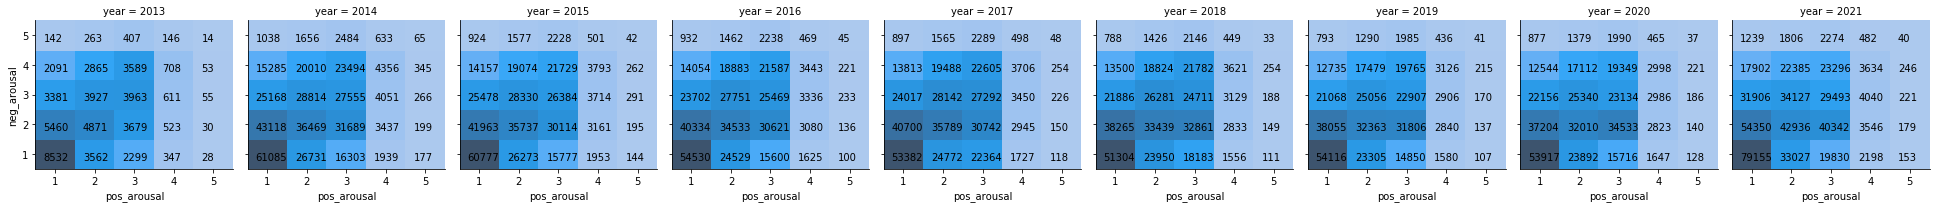

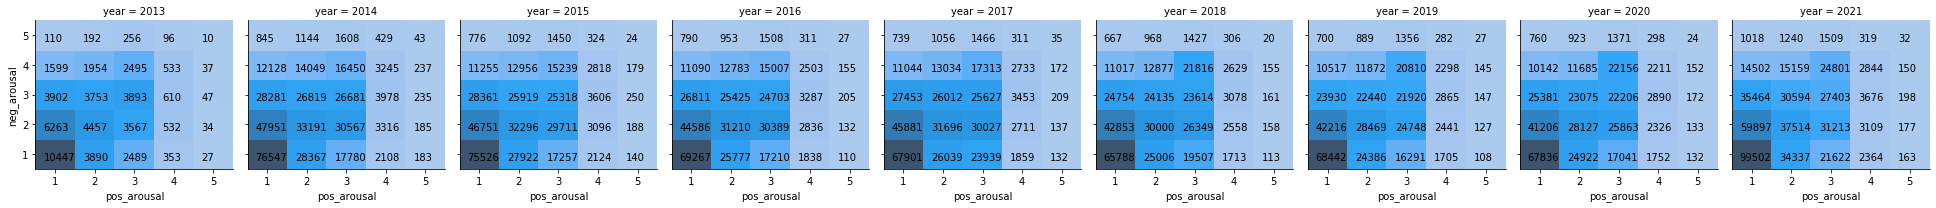

In [71]:
# Create dfs for plotting

plot_dfs = {}

for corp_name in corp_to_analyze:
    for model in ['all','adxs_only','exp','stim']:
        # Create dataframe for plotting, one for each model
        df_id, df_year, df_pos_arousal, df_neg_arousal, df_nrc_val, df_nrc_arousal = [], [], [], [], [], []
        df_emos = {emo: [] for emo in EMOLEX_EMOS}
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if is_valid_utt(utt):
                year = datetime.utcfromtimestamp(utt.timestamp).year
                df_year.append(year)
                df_id.append(utt.id)
                for emo in EMOLEX_EMOS:
                    df_emos[emo].append(utt.meta[f'emo_{model}_{emo}'])
                if (model == 'all') or (model == 'adxs_only'):
                    senti_score = utt.meta[f'senti_{model}'] 
                    df_pos_arousal.append(senti_score[0])
                    df_neg_arousal.append(abs(senti_score[1]))
                    nrc_score = utt.meta[f'nrc_{model}']
                    nrc_valence = nrc_score['val']
                    nrc_arousal = nrc_score['arousal']
                    df_nrc_val.append(nrc_valence)
                    df_nrc_arousal.append(nrc_arousal)
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'id':df_id,})
        to_plot_df.update({emo: df_emos[emo] for emo in EMOLEX_EMOS})
        if model == 'all' or model == 'adxs_only':
            to_plot_df.update(pd.DataFrame({
                'pos_arousal':df_pos_arousal,
                'neg_arousal':df_neg_arousal,
                'nrc_val': df_nrc_val,
                'nrc_arousal': df_nrc_arousal,
            }))
        
        # Wrangle SS categories
        for i,val in enumerate(['pos','neg']):
            categories=[1,2,3,4,5]
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
            
        plot_dfs[model] = to_plot_df

In [ ]:
# SentiStrength

g = sns.FacetGrid(to_plot_df, col='year', aspect=1)
g.map(sns.histplot, 'pos_arousal', 'neg_arousal')#, ci='sd')
g.fig.axes[0].invert_yaxis()
sns.despine()
for i,col in enumerate(g.col_names):
    ax = g.axes.flat[i]
    x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
    for p_i,pos_level in enumerate(categories):
        for n_i,neg_level in enumerate(categories):
            ax.annotate(str(len(to_plot_df.loc[(to_plot_df['year']==col) &
                                               (to_plot_df['pos_arousal']==pos_level) &
                                               (to_plot_df['neg_arousal']==neg_level)])),
                        xy=(x_locs[p_i]+0.7,y_locs[n_i]+0.8))

plt.savefig(f'figs/senti_dist_over_time_{corp_name}_{model}.png',
            dpi=150,bbox_inches="tight")

In [ ]:
# VADER


In [ ]:
# EmoLex
for corp_name in corp_to_analyze:

    years = list(range(2013,2022))
    topics = ['climate change','other']
    emotions = EMOLEX_EMOS
    for model_name in ['all','adxs_only','exp','stim']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            year = datetime.utcfromtimestamp(utt.timestamp).year
            topic = 'climate change' if utt.meta['is_cc_related_gold'] else 'other'
            for key in utt.meta.keys():
                if key.startswith(f'emolex_{model_name}'):
                    emo = key.split('_')[-1]
                    score = utt.meta[f'emolex_{model_name}_{emo}']
                    df_year.append(year)
                    df_topic.append(topic)
                    df_emo.append(emo)
                    df_emoscore.append(score)
                    df_id.append(utt.id)
                    df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'is_awarded_delta':df_delta
        })
#         for i,val in enumerate(['pos','neg']):
#             if i%2 == 1:
#                 categories=['hi','lo','neut']
#             else:
#                 categories=['neut','lo','hi']
#             to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
#                                                       to_plot_df['{}_arousal'.format(val)],
#                                                       categories=categories,
#                                                       ordered=True)
        plt.rcParams['figure.figsize'] = [10, 5]
        g = sns.FacetGrid(to_plot_df, col='emotion', aspect=1)
        g.map(sns.lineplot, 'year', 'emoscore', ci='sd')
        sns.despine()
        for ax in g.axes[0]:
            ax.set_xlabel('')
            ax.set_ylabel('')
        plt.savefig(f'figs/emolex_scores_over_time_{corp_name}_{model_name}.png',
                    dpi=200,bbox_inches="tight")

## Subtree level (*excluding* OP comments; ignoring OP post texts, removed/deleted, and empty comments; excluding completely removed subtrees)

In [ ]:
# subtree-level scores is just sum of subtree-comments (other than SentiStrength arousals)

def get_subtree_score(feat, model_type, subtree_outcome_utt):
    """
    Returns the subtree-level score for a given feature `feat` + model type `model_type` + subtree
    as indexed by its outcome utt `subtree_outcome_utt`
    """
    if feat == 'senti_pos_arousal':
        return subtree_outcome_utt.meta[f'senti_{model_type}_subtree'][0]
    elif feat == 'senti_neg_arousal':
        return subtree_outcome_utt.meta[f'senti_{model_type}_subtree'][1]
    else:
        path_to_outcome_OP_removed = subtree_outcome_utt.meta['path_to_outcome_OP_removed']
        path_to_outcome_valid_utts = [u_id for u_id in path_to_outcome_OP_removed
                                      if is_valid_utt(get_utt(u_id))]
        return sum([get_utt(u_id).meta[f'{feat}_{model_type}'] for u_id in path_to_outcome_valid_utts])

In [ ]:
# TO DO: make sure script works



In [92]:
subtree_outcome_utts = [utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
                        if (is_outcome_leaf(utt)) and (not is_removed_subtree(utt))]

to_plot_df = pd.DataFrame({
    'subtree_outcome_utt_id': [utt.id for utt in subtree_outcome_utts],
    'count': [1 for utt in subtree_outcome_utts],
    '+delta count': [1 if utt.meta['outcome'] == '+delta' else 0 for utt in subtree_outcome_utts],
    '-delta count': [1 if utt.meta['outcome'] == '-delta' else 0 for utt in subtree_outcome_utts],
    'outcome': [utt.meta['outcome'] for utt in subtree_outcome_utts],
    'conversation_id': [utt.conversation_id for utt in subtree_outcome_utts],
    'timestamp': [get_abs_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
                  for utt in subtree_outcome_utts],})
to_plot_df.update({
    pd.DataFrame({
        f'{feat}_{model_type}': [get_subtree_score(feat, model_type, utt) for utt in subtree_outcome_utts]
        for feat in ['senti_pos_arousal','senti_neg_arousal','nrc_val','nrc_arousal']\
                    + [f'emo_{EMO}' for EMO in EMOLEX_EMOS]
        for model_type in ['all','adxs_only']
    })
})
to_plot_df.update({
    pd.DataFrame({
        f'{feat}_{model_type}': [get_subtree_score(feat, model_type, utt) for utt in subtree_outcome_utts]
        for feat in [f'emo_{EMO}' for EMO in EMOLEX_EMOS]
        for model_type in ['stim','exp']
    })
})
to_plot_df['year'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).year)
to_plot_df['month'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).month)
to_plot_df['year_mo'] = to_plot_df.apply(
    lambda x: f"{x['year']}-{x['month']}", axis=1)
to_plot_df.head(10)

,subtree_outcome_utt_id,count,+delta count,-delta count,outcome,conversation_id,timestamp,senti_all,senti_adxs_only,year,month,year_mo,senti_all_pos,senti_all_neg,senti_adxs_only_pos,senti_adxs_only_neg
0,t1_djhcrq8,1,0,1,-delta,t3_6juc9p,1.498598e+09,"(3, -3)","(3, -3)",2017,6,2017-6,3,-3,3,-3
1,t1_csajf84,1,0,1,-delta,t3_3a7ys8,1.434584e+09,"(3, -3)","(3, -3)",2015,6,2015-6,3,-3,3,-3
2,t1_g99brae,1,0,1,-delta,t3_jdn5or,1.603054e+09,"(2, -2)","(2, -2)",2020,10,2020-10,2,-2,2,-2
3,t1_cqxesmu,1,0,1,-delta,t3_34rgpv,1.430694e+09,"(3, -3)","(3, -3)",2015,5,2015-5,3,-3,3,-3
4,t1_cgmavct,1,0,1,-delta,t3_22dcc4,1.396818e+09,"(3, -3)","(3, -3)",2014,4,2014-4,3,-3,3,-3
5,t1_czbzlk5,1,0,1,-delta,t3_42j5z4,1.453697e+09,"(4, -3)","(4, -3)",2016,1,2016-1,4,-3,4,-3
6,t1_e2xnv4w,1,0,1,-delta,t3_90wbso,1.532270e+09,"(2, -2)","(1, -2)",2018,7,2018-7,2,-2,1,-2
7,t1_dzk8x5u,1,1,0,+delta,t3_8m210m,1.527261e+09,"(1, -1)","(1, -1)",2018,5,2018-5,1,-1,1,-1
8,t1_ejku9e0,1,0,1,-delta,t3_b6ine5,1.553780e+09,"(2, -4)","(2, -4)",2019,3,2019-3,2,-4,2,-4
9,t1_co6kzpf,1,0,1,-delta,t3_2ua80f,1.422686e+09,"(2, -2)","(2, -1)",2015,1,2015-1,2,-2,2,-1


In [94]:
# convert to absolute value after sanity checking
print(to_plot_df['senti_all_neg'].value_counts())
for senti_model in ['all', 'adxs_only']:
    for val_idx,val in enumerate(['pos', 'neg']):
        to_plot_df[f'senti_{senti_model}_{val}'] = to_plot_df[f'senti_{senti_model}'].apply(lambda x: 
                                                                                            abs(x[val_idx]))
print(to_plot_df['senti_all_neg'].value_counts())

-4    377168
-3    346693
-2    300746
-1    128664
-5     50238
Name: senti_all_neg, dtype: int64


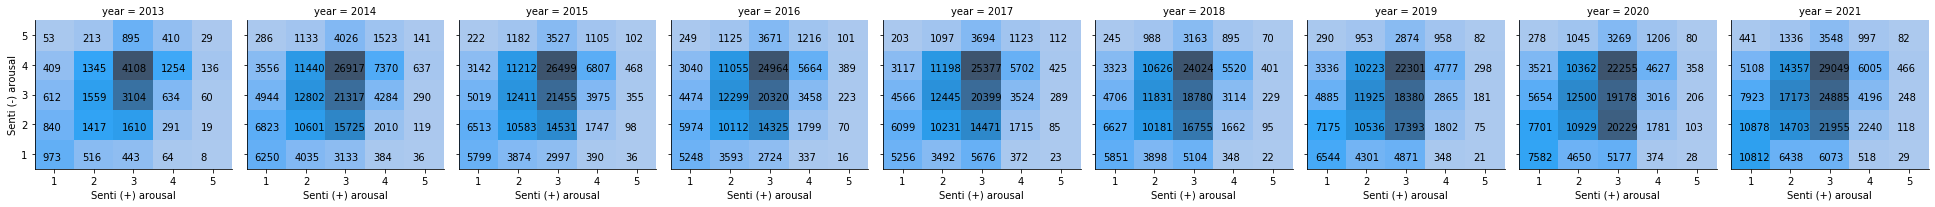

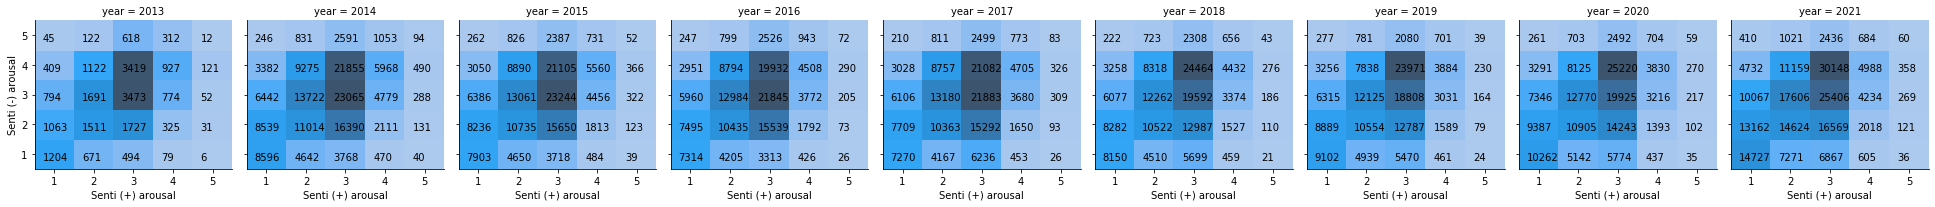

In [97]:
# Wrangle SS categories
categories=[1,2,3,4,5]
for i,val in enumerate(['pos','neg']):
    for senti_model in ['all', 'adxs_only']:
        to_plot_df[f'senti_{senti_model}_{val}'.format(val)] = \
            pd.Categorical(to_plot_df[f'senti_{senti_model}_{val}'.format(val)],
                           categories=categories,
                           ordered=True)

# Create heatmap plots
for senti_model in ['all', 'adxs_only']:
    g = sns.FacetGrid(to_plot_df, col='year', aspect=1)
    g.map(sns.histplot, f'senti_{senti_model}_pos', f'senti_{senti_model}_neg')#, ci='sd')
    g.fig.axes[0].invert_yaxis()
    sns.despine()
    for i,col in enumerate(g.col_names):
        ax = g.axes.flat[i]
        x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
        for p_i,pos_level in enumerate(categories):
            for n_i,neg_level in enumerate(categories):
                ax.annotate(str(len(to_plot_df.loc[(to_plot_df['year']==col) &
                                                   (to_plot_df[f'senti_{senti_model}_pos']==pos_level) &
                                                   (to_plot_df[f'senti_{senti_model}_neg']==neg_level)])),
                            xy=(x_locs[p_i]+0.7,y_locs[n_i]+0.8))
        g.axes[0,i].set_xlabel('Senti (+) arousal')
    g.axes[0,0].set_ylabel('Senti (-) arousal')
    plt.savefig(f'figs/senti_dist_over_time_subtrees_{corp_name}_{senti_model}.png',
                dpi=150,bbox_inches="tight")

# Examine inter-feature correlations

## Lexicon feature overlaps

In [5]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/SentimentLookupTable.txt','r') as f:
    lines = f.read().splitlines()    
senti_dict = {}
for line in lines:
    line_fields = line.split('\t')[:2]
    word, score = line_fields[0], int(line_fields[1])
    senti_dict[word] = score
    
senti_dict_debugged = pd.read_csv('senti_dict.tsv',sep='\t',header=0)

In [14]:
with open('sci_ents.txt','r') as f:
    SCI_ENTS = set(f.read().splitlines())
len(SCI_ENTS)

104

In [15]:
vocabs_dict = {'senti': set([x.replace('*','') for x in senti_dict.keys()]),
               'nrc': set(NRC_vocab),
               'emolex': set(EMOLEX_vocab),
               'mfd': set(MFD_vocab),
               'sci_ents': SCI_ENTS}

lexicon_intersections = defaultdict(dict)
for lexicon1 in vocabs_dict.keys():
    for lexicon2 in vocabs_dict.keys():
        lexicon_intersections[lexicon1][lexicon2] = len(vocabs_dict[lexicon1].intersection(vocabs_dict[lexicon2]))
lexicon_intersections = pd.DataFrame(lexicon_intersections)
lexicon_intersections_norm = lexicon_intersections.divide(np.diag(lexicon_intersections))
lexicon_intersections_norm

,senti,nrc,emolex,mfd,sci_ents
senti,1.000000,0.092118,0.186113,0.122790,0.000000
nrc,0.695209,1.000000,0.974613,0.437623,0.528846
emolex,0.417578,0.289749,1.000000,0.272102,0.115385
mfd,0.094304,0.044534,0.093141,1.000000,0.000000
sci_ents,0.000000,0.002749,0.002017,0.000000,1.000000


In [32]:
for lexicon in vocabs_dict:
    print(f'Size of {lexicon.upper()}: {len(vocabs_dict[lexicon])}')

Size of SENTI: 2651
Size of NRC: 20007
Size of EMOLEX: 5948
Size of MFD: 2036
Size of SCI_ENTS: 104


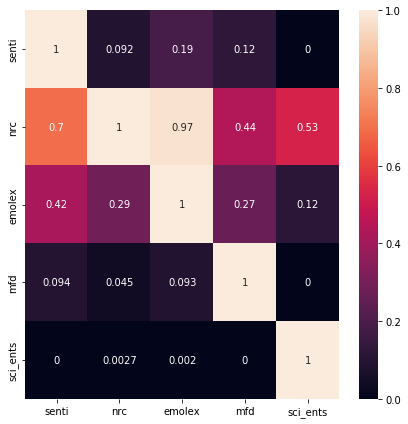

In [29]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(lexicon_intersections_norm, annot=True, cbar=True, ax=ax)
plt.tight_layout()
plt.savefig('figs/lexicon_overlaps.png',dpi=200)

In [21]:
NRC.loc[NRC['Word'].isin(vocabs_dict['sci_ents'])].sort_values(['Arousal','Valence'],ascending=False)

,Word,Valence,Arousal,Dominance
6296,experiment,0.479,0.720,0.675
14796,research,0.633,0.663,0.741
6300,expert,0.776,0.646,0.911
5050,discovery,0.823,0.627,0.814
1050,assessment,0.750,0.623,0.658
17899,thesis,0.583,0.582,0.552
2898,chemist,0.408,0.575,0.610
5190,dissertation,0.312,0.575,0.575
16075,simulation,0.552,0.574,0.567
16586,specialist,0.760,0.562,0.877


In [23]:
EMOLEX.loc[EMOLEX['word'].isin(vocabs_dict['sci_ents'])].sort_values(['emotion-intensity-score'],ascending=False)

,word,emotion,emotion-intensity-score
8481,scientist,trust,0.695
8562,expert,trust,0.664
8567,specialist,trust,0.664
8784,assessment,trust,0.594
1704,experiment,anticipation,0.580
8844,professor,trust,0.578
8956,physicist,trust,0.555
9013,institute,trust,0.539
1908,calculation,anticipation,0.500
5936,scholarship,joy,0.455


## Visualize/test correlations